In [13]:
from brian2 import *
%matplotlib inline

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


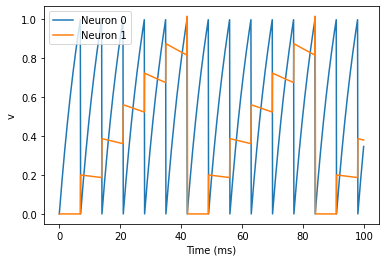

In [14]:
start_scope()

eqs = '''
dv/dt = (I - v)/tau: 1
I : 1
tau : second
'''

G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method = 'exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Synapse
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i = 0, j = 1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label = 'Neuron 0')
plot(M.t/ms, M.v[1], label = 'Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

In [15]:
soma = Soma(diameter=30*um)
cylinder = Cylinder(diameter=1*um, length=100*um, n=10)

In [16]:
morpho = Soma(diameter=30*um)
morpho.axon = Cylinder(length=100*um, diameter=1*um, n = 10)
morpho.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)


In [17]:
morpho.dendrite.spine = Cylinder(length=40*um, diameter=1*um, n = 3)

In [18]:
new_morpho = morpho.generate_coordinates()

In [19]:
print(new_morpho)

Soma(diameter=30. * umetre, x=0. * metre, y=0. * metre, z=0. * metre)


In [20]:
gL = 1e-4*siemens/cm**2
EL = -70*mV
eqs = '''
Im = gL * (EL - v) : amp/meter**2
I : amp (point current)'''
# Im is the total transmembrane current

neuron = SpatialNeuron(morphology = morpho, model = eqs, Cm = 1*uF/cm**2, Ri = 100*ohm*cm)
neuron.v = EL + 10*mV

In [21]:
l = neuron.space_constant[0]
tau = neuron.time_constant[0]

In [22]:
neuron.I[0] = 1*nA

In [23]:
print(neuron.v)

<spatialneuron.v: array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
       -60., -60., -60., -60., -60., -60., -60., -60.]) * mvolt>


In [24]:
eqs='''
Im = gL*(EL - v) : amp/meter**2
Is = gs*(Es - v) : amp (point current)
dgs/dt = -gs/taus : siemens
'''
neuron = SpatialNeuron(morphology=morpho, model = eqs, Cm = 1*uF/cm**2, Ri = 100*ohm*cm)

### Neuron Morphology: Spine

soma - dendrite - spine

Check for voltage in soma after including some input at the spine.

In [25]:
morph = Soma(diameter = 30*um)
morph.dendrite = Cylinder(diameter = 1*um, length = 100*um, n = 1)
morph.dendrite.spine = Cylinder(diameter = 0.1*um, length = 10*um, n = 1)


In [26]:
new_morpho = morph.generate_coordinates()

In [28]:
print(new_morpho)

Soma(diameter=30. * umetre, x=0. * metre, y=0. * metre, z=0. * metre)


In [ ]:
# EQUATIONS

'''
dV/dt = (I - v)/tau_Soma: mVolt
 
'''
